In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lasio
import os 

In [4]:
def igr(gr,grmin,grmax):
    return (gr-grmin)/(grmax-grmin)

def vsh_stieber(igr,agr=3):
    return igr/(agr-(agr-1)*igr)

def vsh_larionov_cretaceous(igr):
    return 0.33*(2**(2*igr)-1)

def vsh_nd(phin,phid,phin_sh,phid_sh):
    return (phin-phid)/(phin_sh-phid_sh)

def phi_rhob(rhob,rho_matrix=2.65,rho_f=1):
    return (rho_matrix-rhob)/(rho_matrix-rho_f)

def phi_sonico(dt,dt_matrix=55.5,dt_f=189):
    return (dt-dt_matrix)/(dt_f-dt_matrix)

def phi_n_corr(phin):
    if np.mean(phin)>1:
        return phin/100 - 0.04
    else:
        return phin - 0.04

## Propriedades petrofísicas das rochas

O perfil de Raios Gama é uma ferramenta amplamente utilizada em toda atividade de perfilagem. Este perfil mede a radioatividade natural emitida por rochas e sedimentos que ocorrem principalmente devido a presença dos elementos químicos potásio ($^{40}K$), tório ($^{232}Th$) e urânio ($^{238}U$). A intensidade da contagem de raios gama (dada em uAPI) é diretamente correlacionável com a argilosidade das rochas. As suas principais aplicações são:

* Identificação de litologia - Distinção entre rochas argilosas (folhelhos e não-folhelhos) e distinção de rochas não-argilosas (arenitos, calcários e dolomitos); e
* Correlação estratigráfica - Correlação entre camadas litológicas e estratigráficas, a âmbito de poço, para mapeamento de uma unidade de reservatório ou ambiente sedimentar. 

### Argilosidade

A argilosidade é definida como o conteúdo dominante de argila em uma formação não-argilosa. A estimativa dessa propriedade em poço é realizada através do cálculo do IGR (Índice de Raios Gama) que é uma normalização do perfil geofísico.

$$IGR = \frac{GR-GR_{min}}{GR_{max}-GR_{min}}$$

Veja que o IGR trata-se de uma normalização que apresenta a argilosidade da rocha como se fosse uma relação linear entre o valor do GR medido e a argilosidade calculada. Existem diversos modelos aceitas que podem ser utilizadas para o cálculo da argilosidade em diferentes contextos:

$$V_{SH_{Larionov_{older cenozoic}}} = 0.33 \left( 2^{(2 \cdot IGR)} - 1 \right)$$

$$V_{SH_{Larionov_{TertiaryRocks}}} = 0.083 \left( 2^{(3.7 \cdot IGR)} - 1 \right)$$

$$V_{SH_{Steiber}} = \frac{IGR}{3 - 2 \cdot IGR}$$

$$V_{SH_{Clavier}} = 1.7 - \sqrt{3.38 - (IGR + 0.7)^2}$$




In [7]:
df = pd.read_csv('../Dados/well.csv',index_col=[0])
df.head()

,GR,M2R1,M2R2,M2R3,M2R6,M2R9,DT,ZDEN,ZCOR,CNC,log,Formação
3827.6784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LIS_003,Jureia
3827.8308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LIS_003,Jureia
3827.9832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LIS_003,Jureia
3828.1356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LIS_003,Jureia
3828.2880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LIS_003,Jureia


c:\Users\Acer3\anaconda3\envs\proj_petro\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


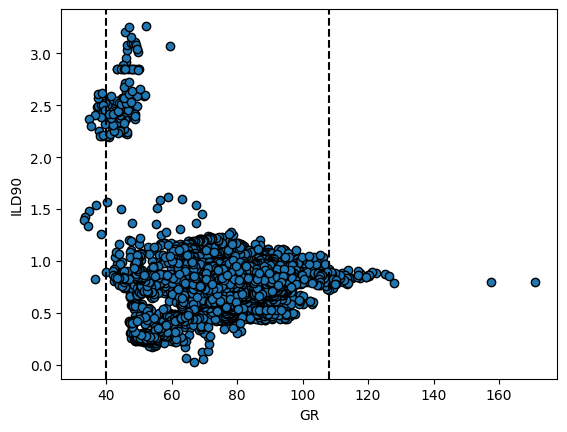

In [8]:
#Determinando GR minimo e máximo
fig, axes = plt.subplots()

ax=axes.scatter(df[df.GR>0].GR,np.log10(df[df.GR>0].M2R9),
                edgecolor='black')
axes.set_xlabel('GR')
axes.set_ylabel('ILD90')

gr_min,gr_max = 40,108

axes.axvline(gr_min,color='black',ls='--')
axes.axvline(gr_max,color='black',ls='--')

In [9]:
df['igr'] = igr(df.GR,grmin=gr_min,grmax=gr_max)
df['vsh'] = vsh_larionov_cretaceous(df.igr)

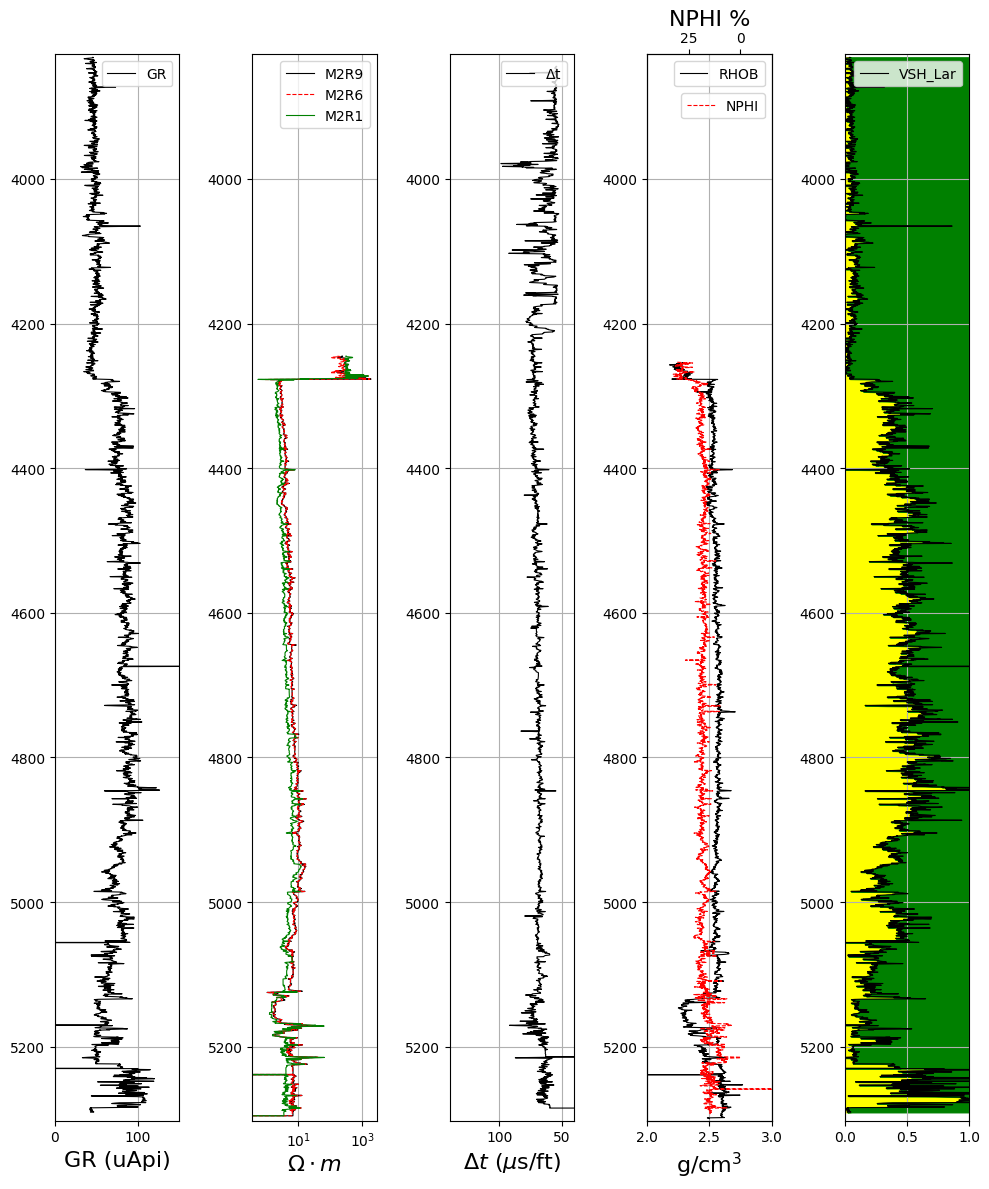

In [10]:
fig,axes = plt.subplots(ncols=5,figsize=(10,12))

for ax in axes:
    ax.invert_yaxis()
    ax.set_ylim(df.index.max(),df.index.min())
    ax.grid()

axes[0].plot(df.GR,df.index,lw=0.8,color='black',label='GR')
axes[0].set_xlim(0,150)
axes[0].set_xlabel('GR (uApi)',fontsize=16)
axes[0].legend(loc='upper right')

axes[1].semilogx(df.M2R9,df.index,lw=0.8,color='black',label='M2R9')
axes[1].semilogx(df.M2R6,df.index,color='red',lw=0.8,ls='--',label='M2R6')
axes[1].semilogx(df.M2R1,df.index,color='green',lw=0.8,label='M2R1')
axes[1].set_xlabel(r'$\Omega \cdot m$',fontsize=16)
axes[1].legend(loc='upper right')


axes[2].plot(df.DT,df.index,lw=0.8,color='black',label=r'$\Delta$t')
axes[2].set_xlim(140,40)
axes[2].set_xlabel(r'$\Delta t$ ($\mu$s/ft)',fontsize=16)
axes[2].legend(loc='upper right')

axes[3].plot(df.ZDEN,df.index,lw=0.8,color='black',label='RHOB')
axes[3].set_xlim(2,3)
axes[3].set_xlabel(r'g/cm$^3$',fontsize=16)
axes[3].legend(loc='upper right')

axes2 = axes[3].twiny()

axes2.plot(df.CNC,df.index,lw=0.8,color='red',ls='--',label='NPHI')
axes2.set_xlabel('NPHI %',fontsize=16)
axes2.set_xlim(45,-15)
axes2.legend(loc='upper right',bbox_to_anchor=(1,0.97))

axes[4].plot(df.vsh,df.index,lw=0.8,color='black',label='VSH_Lar')
axes[4].fill_betweenx(y=df.index,x2=df.vsh,x1=0,color='yellow')
axes[4].fill_betweenx(y=df.index,x2=df.vsh,x1=2,color='green')
axes[4].set_xlim(0,1)
axes[4].legend(loc='upper right')


fig.tight_layout()

## Perfis de resistividade

Os perfis de resistividade foram inicialmente desenvolvidos para pesquisa de hidrocarbonetos, apesar de hoje serem úteis na perfilagem de recursos hídricos, minerais ou elementos geotécnicos. A priori, utilizaremos os perfis de indução elétrica, cujo o princípio da ferramenta se dá através do eletromagnetismo, onde a ferramenta é composta por uma bobina emissora e receptora, onde uma corrente alternada de alta frequência induz uma corrente secundária na formação e está última é detectada por uma bobina receptora.

A priori, Enunciemos a equação de Archie:

$$S_w = \left( \frac{Rw}{R_t \phi^m} \right)^\frac{1}{n}$$

$S_w$ - Saturação de água, ou fração de água que preenche os poros;
$R_w$ - Resistividade do fluido de formação;
$R_t$ - Resistividade da formação (comumente medida pelo log de resistividade);
$\phi$ - Porosidade da formação;
$m$ - Coeficiente de cimentação, é um fator que reflete a disposição dos grãos da rocha e dos poros; e
$n$ - Expoente de saturação, que é dependente da forma como a água está preenchendo os poros.

Veja que essa equação tem uma relação direta com a medida da resistividade do meio e do fluido que o preenche. Entrentanto, é importante saber os perfis de resistividade podem ser divididos em perfis de investigação rasa, média e profunda.

![](https://geohazard009.files.wordpress.com/2015/02/borehole_env.jpg "Modelo esquemático do poço e formação usado para descrever as medidas de log de resistividade (Sclumberger)")

<img src="../Figs/Form_invasion.png" alt="Invasão do fluido" width="400"/>
